По условиям задачи необходимо проанализировать работу интернет-магазина "Стримчик", который занимается продажей компьютерных 
игр. На основании исторических данных нужно определить факторы, определяющие успешность игры. Полученные данные будут
использоваться при разработке новых игровых продуктов. Поставленные задачи будет выполняться в стандартной последовательности:
- предварительная обработка данных
- расчеты и ответы на поставленные вопросы

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

Загрузка библиотек

In [3]:
data = pd.read_csv('/datasets/games.csv')
data.head(10)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Загрузка и первичное ознакомление с файлом. Общее количество записей порядка 16 тысяч. Данные требуют предварительной обработки перед анализом

In [4]:
print(data.duplicated().sum())

0


Задвоения строк не обнаружены

In [5]:
data.columns = data.columns.str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Названия столбцов переведены в нижний регистр 

In [6]:
data['year_of_release'] = data['year_of_release'].fillna(data['year_of_release'].mean())
data['year_of_release'] = data['year_of_release'].astype('int')
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Отсутствие данных о годе выпуска игры является, скорее всего, следствием человеческого фактора. Год выпуска неизвестен менее 
чем для 2% выборки и, соответственно, не может существенным образом повлиять нa результаты анализа. В связи с эти пропуски 
заменены на средние значения. Для удобства восприятия и экономии ресурсов формат изменен с float64 на integer. В колонках critic_score, user_score, rating доля пропущенных значений велика. Она не может быть заменена средним так как это может привести к искажению данных. Поэтому пропущенные значения ничем не заменяются. Наиболее вероятной причиной пропусков является отсутствие соответствующих данных.

In [7]:
data.loc[data.loc[:, 'user_score']=='tbd']['user_score'].count()

2424

В колонке user_score присутствует значение tbd. Скорее всего оно расшифровывается как to be determined и в практическом смысле означает отсутствие данных. Значение tbd можно заменить на Nan

In [8]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)
data.loc[data.loc[:, 'user_score']=='tbd']['user_score'].count()
data['user_score'] = data['user_score'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


tbd заменен на Nan. Тип данных в колонке заменен на более подходящий float

In [9]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
data.head(50)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31


Добавлены данные с общими продажами

In [10]:
data_by_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
display(data_by_year)

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


В соответствии с условиями задачи рассчитано количество выпущенных игр в разрезе  по годам

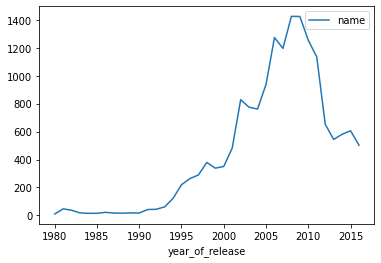

In [11]:
data_by_year = data_by_year.reset_index()
data_by_year.head()
data_by_year.plot(x='year_of_release', y='name');

Представление результатов в графическом виде. В 1980-1990 годы выпускалось минимальное количество игр

In [12]:
data_by_platform = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
display(data_by_platform)

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


Продажи в разрезе по платформам

In [13]:
data_by_platform = data_by_platform.reset_index()
best_platforms = data_by_platform['platform'].head(6)
display(best_platforms)

0     PS2
1    X360
2     PS3
3     Wii
4      DS
5      PS
Name: platform, dtype: object

Наиболее популярными платформами в рассматриваемый период являлись PS2, X360, PS3, Wii,  DS, PS 

<AxesSubplot:ylabel='Frequency'>

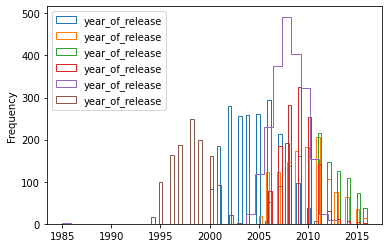

In [14]:
data_ps2 = data[data['platform'] == 'PS2'] 
data_ps2_by_year = data_ps2.pivot_table(index='year_of_release', values='name', aggfunc='count')
data_x360 = data[data['platform'] == 'X360'] 
data_x360_by_year = data_x360.pivot_table(index='year_of_release', values='name', aggfunc='count')
data_ps3 = data[data['platform'] == 'PS3'] 
data_ps3_by_year = data_ps3.pivot_table(index='year_of_release', values='name', aggfunc='count')
data_wii = data[data['platform'] == 'Wii'] 
data_wii_by_year = data_wii.pivot_table(index='year_of_release', values='name', aggfunc='count')
data_ds = data[data['platform'] == 'DS'] 
data_ds_by_year = data_ds.pivot_table(index='year_of_release', values='name', aggfunc='count')
data_ps = data[data['platform'] == 'PS'] 
data_ps_by_year = data_ps.pivot_table(index='year_of_release', values='name', aggfunc='count')
ax = data_ps2.plot(kind='hist', y='year_of_release', histtype='step', bins=30)
data_x360.plot(kind='hist', y='year_of_release', histtype='step', bins=30, ax=ax, legend=True)
data_ps3.plot(kind='hist', y='year_of_release', histtype='step', bins=30, ax=ax, legend=True)
data_wii.plot(kind='hist', y='year_of_release', histtype='step', bins=30, ax=ax, legend=True)
data_ds.plot(kind='hist', y='year_of_release', histtype='step', bins=30, ax=ax, legend=True)
data_ps.plot(kind='hist', y='year_of_release', histtype='step', bins=30, ax=ax, legend=True)


Характерный срок жизни платформы находится в пределах 10 лет. Для дальнейших расчетов будут использоваться данные за 2015-2016 годы

In [15]:
data_relevant = data[data['year_of_release'] > 2014] 
data_relevant_by_platform = data_relevant.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
display(data_relevant_by_platform)

,total_sales
platform,
PS4,188.15
XOne,86.29
3DS,42.92
WiiU,20.95
PS3,20.42
PC,13.77
X360,13.48
PSV,10.50
Wii,1.32


Лидеры продаж за выбранный период это платформы PS4, XOne, 3DS, WiiU и PS3

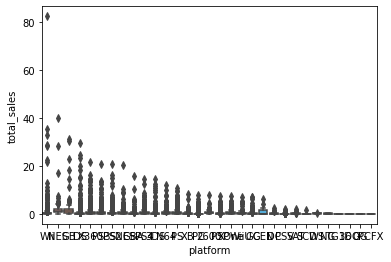

In [37]:
sns.boxplot(x=data['platform'], y=data['total_sales'])
plt.show()

Анализ распределения подтверждает общее правили: есть ограниченное число игр-блокбастеров с продажами, существенно превышающими средние

In [33]:
data_relevant[data_relevant['platform'] == 'PS4'].corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
year_of_release,1.000000,-0.164633,-0.125109,-0.079977,-0.155549,-0.018455,0.016125,-0.152557
na_sales,-0.164633,1.000000,0.747461,0.446473,0.936805,0.406409,-0.026921,0.917233
eu_sales,-0.125109,0.747461,1.000000,0.417355,0.932506,0.310625,-0.086974,0.948745
jp_sales,-0.079977,0.446473,0.417355,1.000000,0.462652,0.366784,0.185471,0.496600
other_sales,-0.155549,0.936805,0.932506,0.462652,1.000000,0.394959,-0.065671,0.997817
critic_score,-0.018455,0.406409,0.310625,0.366784,0.394959,1.000000,0.533330,0.392849
user_score,0.016125,-0.026921,-0.086974,0.185471,-0.065671,0.533330,1.000000,-0.059738
total_sales,-0.152557,0.917233,0.948745,0.496600,0.997817,0.392849,-0.059738,1.000000


Зависимость продаж игр на платформе PS4 от отзывов критиков ограниченная, коэффициент корреляции 0.39 Зависимость продаж от отзывов пользователей отсутствует, коэффициент корреляции -0.06

In [ ]:
data_relevant[data_relevant['platform'] == 'PS4'].plot(x='critic_score', y='total_sales', kind='scatter', figsize=(6,4));
data_relevant[data_relevant['platform'] == 'PS4'].plot(x='user_score', y='total_sales', kind='scatter', figsize=(6,4));

Графическое представление зависимости

In [ ]:
data_relevant[data_relevant['platform'] == 'XOne'].corr()

По платформе XOne корреляция 0.42 и -0.04 соответственно

In [ ]:
data_relevant[data_relevant['platform'] == '3DS'].corr()

По платформе 3DS корреляция 0.18 и 0.20 соответственно

In [ ]:
data_relevant[data_relevant['platform'] == 'WiiU'].corr()

По платформе WiiU корреляция 0,33 и 0,36 соответственно

In [ ]:
data_relevant[data_relevant['platform'] == 'PS3'].corr()

По платформе PS4 корреляция c оценками пользователей -0.17 соответственно. Оценки критиков отсутствуют, соответственно, корреляцию рассчитать невозможно. Анализируя наиболее популярные платформы можно отметить общий тренд: ограниченная корреляция с мнением критиков и практически отсутствующая с мнением пользователей

In [ ]:
data_platforms_best = data_relevant.pivot_table(index='genre', values='total_sales', aggfunc='median').sort_values(by='total_sales', ascending=False)
display(data_platforms_best)

В качестве критерия успешности жанра выбрана медиана продаж. Это позволит исключить влияние отдельных сверхуспешных игр. Исходя
из данного критерия наиболее успешными жанрами являются Shooter, Fighting, Sports, Role-Playing и Action

In [ ]:
data_relevant['rating'] = data_relevant['rating'].fillna(0)
data_relevant.tail()

In [ ]:
data_relevant.info()
data_relevant['rating'].value_counts()

Отсутствующие значения NaN в колонке rating заменены на 0 чтобы все игры попали в дальнейшие расчеты

In [ ]:
top_na = data_relevant.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
top_na['share'] = top_na['na_sales'] / top_na['na_sales'].sum()
top_na.head()

В Северной Америке наиболее популярными платформами являются PS4 и XOne c долями рынка 42% и 33% соответственно. Существенно менее популярным являются платформы 3DS, WiiU, X360 с долями в пределах в 5-7%

In [ ]:
top_eu = data_relevant.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
top_eu['share'] = top_eu['eu_sales'] / top_eu['eu_sales'].sum()
top_eu.head()

В Европейском Союзе наиболее популярной является платформа PS4, занимающая 57% рынка. Далее опять идет XOne с долей в 20%. Замыкают пятерку лидеров PC, WiiU, PS3 с долями в пределах 4-7%

In [ ]:
top_jp = data_relevant.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
top_jp['share'] = top_jp['jp_sales'] / top_jp['jp_sales'].sum()
top_jp.head()

В Японии наиболее популярными платформами являются PS4 и 3DS с долями в 34% b 24%. За ними следуют WiiU, PSV, PS3 c долями в 19%, 13% и 9% соответственно. 
Сравнивая популярность различных платформ можно выделить явного лидера во всех регионах присутствия платформу PS4. XOne занимает второе место в Северной Америке и Европе. Также среди лидеров можно отметить платформы 3DS, WiiU, PS3

In [ ]:
top_na_genre = data_relevant.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
top_na_genre['share'] = top_na_genre['na_sales'] / top_na_genre['na_sales'].sum()
top_na_genre.head()

Наиболее популярным жанром в Северной Америке является Shooter c долей в 32%. Далее идут Action, Sports и Role-Playing с долями 
22%, 17% и 13% соответственно

In [ ]:
top_eu_genre = data_relevant.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
top_eu_genre['share'] = top_eu_genre['eu_sales'] / top_eu_genre['eu_sales'].sum()
top_eu_genre.head()

Лидеры в Европе в целом совпадают с таковыми в Америке. Жанры Action, Sports, Shooter, Role-Playing  занимают доли в 26%, 24% и 22% и 11% соответственно. 

In [ ]:
top_jp_genre = data_relevant.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
top_jp_genre['share'] = top_jp_genre['jp_sales'] / top_jp_genre['jp_sales'].sum()
top_jp_genre.head()

Предпочтения пользователей в Японии достаточно схожи с первыми двумя регионами. Лидером является Action с долей в 27 %. Далее идет Role-Playing (23%) и Shooter(16%). Менее популярными являются Simulation и Platform с долями 8% и 7% соответственно

In [ ]:
na_rating = data_relevant.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
na_rating

В Северной Америке наиболее популярны игры с рейтингами M, E, T, E10+

In [ ]:
eu_rating = data_relevant.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
eu_rating

В Европе предпочтения по рейтингам полностью совпадают с таковыми в Америке

In [ ]:
jp_rating = data_relevant.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
jp_rating

В Японии список лидеров совпадает с другими регионами, только T и M поменялись местами

In [ ]:
data_01 = data_relevant.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
data_01

In [ ]:
data_relevant = data_relevant.dropna(subset=['user_score'])
data_xone = data_relevant[data_relevant['platform'] == 'XOne']
data_pc = data_relevant[data_relevant['platform'] == 'PC']
results = st.ttest_ind(data_xone['user_score'], data_pc['user_score'])
results.pvalue

Данный расчет проверяет гипотезу о равенстве средних пользовательских рейтингов платформ XOne и PC. Нулевая гипотеза предполагает равенство средних. Alpha = 0.05 t-test показывает что вероятность равенства составляет 0.055. Соответственно, 
нулевая гипотеза о равенстве средних принимается

In [ ]:
data_action = data_relevant[data_relevant['genre'] == 'Action']
data_sports = data_relevant[data_relevant['genre'] == 'Sports']
results = st.ttest_ind(data_action['user_score'], data_sports['user_score'])
results.pvalue

Данный расчет проверяет гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports. Нулевая гипотеза предполагает равенство средних. Alpha = 0.05 t-test показывает что вероятность равенства составляет неотличимую от нуля величину, 10 в минус двенадцатой степени. Соответственно, нулевая гипотеза о равенстве средних отвергается и предположение о различии в рейтингах верное

В данном проекте было проанализированы данные о продажах компьютерных игр на основе исторических данных за 37 лет. Размер выборки пользоволял использоваться стандартные методы теории вероятности. Исходя из динамики продаж был определен средний срок жизни платформы, который составляет 10 лет. Анализ проводился на основе данных за последние два года и выявил следующие закономерности:
- неравномерное распределение популярности конкретных игр, наличие блокбастеров в каждой категории
- доминирующее положение ограниченного количества платформ
- слабую корреляцию популярности игры с мнением критиков и пользователей
- существенное сходство потребительского поведения в основных регионах продаж: Северной Америке, Европе и Японии
Данные факторы могут быть использованы при разработке новых игр